In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import re
import string

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

import spacy
from spacy_download import load_spacy
import lemminflect
from lemminflect import getInflection

import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
import gensim.corpora as corpora

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

import bitermplus as btm


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cynthiayip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [236]:
journey = pd.read_csv('patient_journey.csv', index_col=0)
journey.head()

PatientID  \
0      P001   
1      P002   
2      P003   
3      P004   
4      P005   

                                                                                                                                                                                                                              Journey/MajorEvents  
0                                                                                                                                                                                                                                             NaN  
1                                                                                                                                                                                                                                             NaN  
2  4/2: Drove to Noah's 10:00 AM. 7:00 PM felt good throughout the day but tired at bedtime. Ear ringing. Moderate headache\n\n4/3: Ears ringing. Fatigue. Went to museum and [uninteligible] would noise at [uninteligible]. Walked quite a bit.  
3                                                                                                                                                                                                                                             NaN  
4                                                                                                                                                                                                                                             NaN

In [237]:
journey.shape

(655, 2)

In [238]:
# check no. of rows with null values
journey['Journey/MajorEvents'].isnull().sum()

22

# Pre-processing

In [239]:
# drop null values
journey = journey.dropna()
journey.head()

PatientID  \
2      P003   
5      P006   
6      P007   
7      P008   
8      P009   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [240]:
journey.shape

(633, 2)

In [241]:
journey['Journey/MajorEvents'] = journey['Journey/MajorEvents'].astype(str)

In [242]:
# data preprocessing

# remove punctuation
journey['Journey/MajorEvents_Processed'] = \
journey['Journey/MajorEvents'].map(lambda x: re.sub('[,\./-/:%!?]', '', x))

# remove text in square brackets
journey['Journey/MajorEvents_Processed'] = \
journey['Journey/MajorEvents_Processed'].map(lambda x: re.sub('\[.*?\]', '', x))

# remove numbers
journey['Journey/MajorEvents_Processed'] = \
journey['Journey/MajorEvents_Processed'].map(lambda x: re.sub('\w*\d\w*', '', x))

# remove newline characters
journey['Journey/MajorEvents_Processed'] = \
journey['Journey/MajorEvents_Processed'].map(lambda x: re.sub('[\n]', '', x))

# convert to lower case
journey['Journey/MajorEvents_Processed'] = \
journey['Journey/MajorEvents_Processed'].map(lambda x: x.lower())

# print first rows
journey_processed = journey[['PatientID', 'Journey/MajorEvents_Processed']]
journey_processed.head()

PatientID  \
2      P003   
5      P006   
6      P007   
7      P008   
8      P009   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Journey/MajorEvents_Processed  
2                                                     

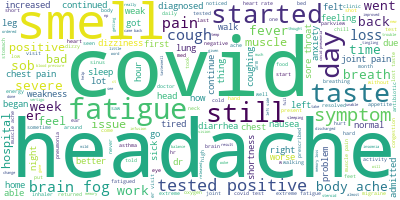

In [243]:
# visualize data

# join the processed text
long_string = ','.join(list(journey_processed['Journey/MajorEvents_Processed'].values))

# create a WordCloud object
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

In [244]:
# tokenization
def send_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data = journey['Journey/MajorEvents_Processed'].values.tolist()
data_words = list(send_to_words(data))

print(data_words[:1])

[['drove', 'to', 'noah', 'am', 'pm', 'felt', 'good', 'throughout', 'the', 'day', 'but', 'tired', 'at', 'bedtime', 'ear', 'ringing', 'moderate', 'headache', 'ears', 'ringing', 'fatigue', 'went', 'to', 'museum', 'and', 'would', 'noise', 'at', 'walked', 'quite', 'bit']]


In [245]:
# check the stop word list in the default NLTK library
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [246]:
# function for removing stop words testing
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
            if word not in stop_words] for doc in texts]

stop_words = stopwords.words('english')
stop_words.remove('am')
# add additional stop words
stop_words.extend(['covid', 'positive', 'still', 'er', 'test', 'symptoms', 'dr', 'really'])


# function for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token._.lemma() for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [247]:
# # function for removing stop words
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc))
#             if word not in stop_words] for doc in texts]

# stop_words = stopwords.words('english')
# stop_words.remove('am')
# # add additional stop words
# stop_words.extend(['covid', 'tested positive', 'positive', 'still', 'er', 'tested', 'symptoms', 'dr', 'really'])


# # function for lemmatization
# def lemmatization_1(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent))
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [248]:
# lemmatization keeping propn, noun, adj, verb, and adv
nlp = spacy.load("en_core_web_sm")
data_lemmatized = lemmatization(data_words, allowed_postags=['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV'])

# remove stop words
data_words_nostops = remove_stopwords(data_lemmatized)

Traceback (most recent call last):
  File "/Users/cynthiayip/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/cynthiayip/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/cynthiayip/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/cynthiayip/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/cynthiayip/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/cynthiayip/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/cynthiayip/opt/anaconda3/lib/python3.8/mult

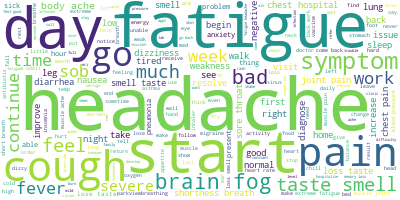

In [250]:
# wordcloud after removing stopwords

# join the text
s = data_words_nostops
long_string = ' '.join([str(words) for words in s])

# create a WordCloud object
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string.replace("'", ''))

# visualize the word cloud
wordcloud.to_image()

# Method 1: LDA

In [35]:
# create dictionary
id2word = corpora.Dictionary(data_words_nostops)

# create corpus
texts = data_words_nostops # Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1)]


In [158]:
# run LDA model for number of topics = 1-50

num_topics = list(range(52)[1:])
num_keywords = 20
lda_models = {}
lda_topics = {}

for i in num_topics:
    lda_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i, 
                             random_state=12321)
    
    shown_topics = lda_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    
    lda_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

### Model Evaluation (LDA)

In [159]:
# average of overlapping top 20 words among topics per number of topics

lda_count = {}
lda_count_list = []
for i in range(1, len(num_topics)):
    count_per_model = []
    for j in range (0, len(lda_topics[i])-1):
        topic1 = lda_topics[i][j]
        rest_of_topics = list(lda_topics.values())
        count_per_1topic = []
        for topic2 in rest_of_topics.pop(j):
            count_tmp = sum(t in topic1 for t in topic2)
            
            #count_per_model = number_of_duplicates(topic1, list)
            count_per_1topic.append(count_tmp)
            count_per_1topic_1 = np.average(count_per_1topic)
            
        count_per_model.append(count_per_1topic_1)
        lda_count[i] = np.average(count_per_model)

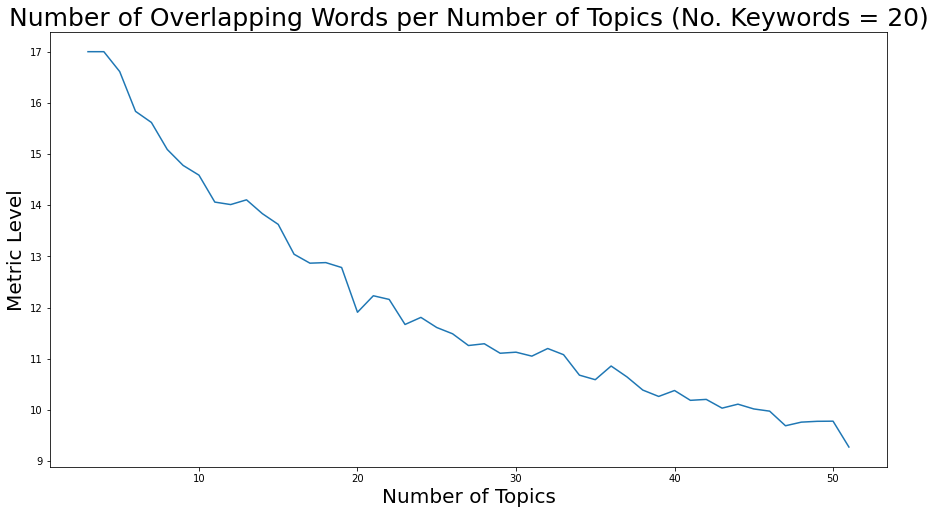

In [160]:
# visualization of Numver of Overlapping Words per Number of Topics (No. Keywords = 10)
plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[2:51], y=lda_count.values())

ax.axes.set_title('Number of Overlapping Words per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
#plt.legend(fontsize=20)
plt.show()

In [161]:
# get perplexity
lda_perplexity = [2**(-lda_models[i].log_perplexity(corpus))\
                  for i in num_topics[:-1]]

# get coherence (cv)
lda_coherences_cv = [CoherenceModel(model=lda_models[i], texts=data_words_nostops, coherence='c_v').get_coherence()\
                  for i in num_topics[:-1]]

# get coherence (umass)
lda_coherences_umass = [CoherenceModel(model=lda_models[i], corpus=corpus, coherence='u_mass').get_coherence()\
                  for i in num_topics[:-1]]

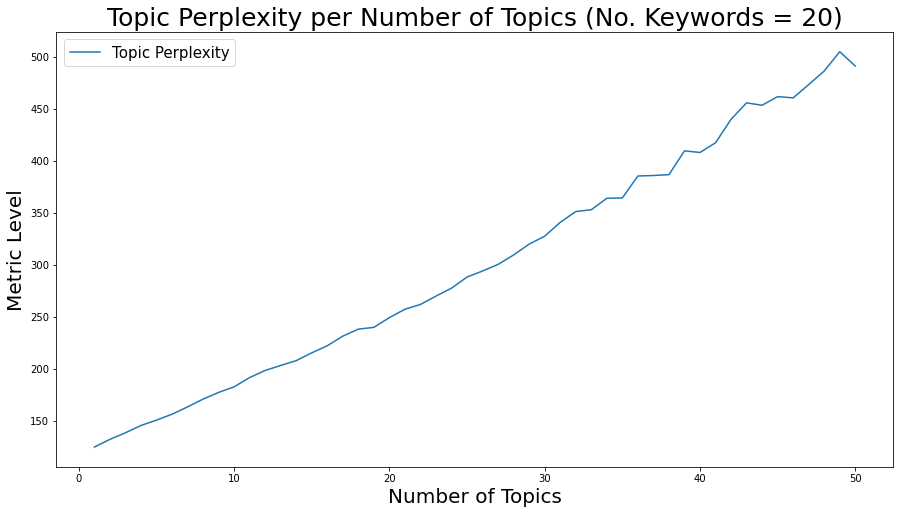

In [162]:
# visualization of Topic Perplexity

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[:-1], y=lda_perplexity, label='Topic Perplexity')
#ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_cv, label='Topic Coherences (c_v)')
#ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherences (u_mass)')

#ax.set_ylim([-3, y_max])

ax.axes.set_title('Topic Perplexity per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=15)
plt.show() 

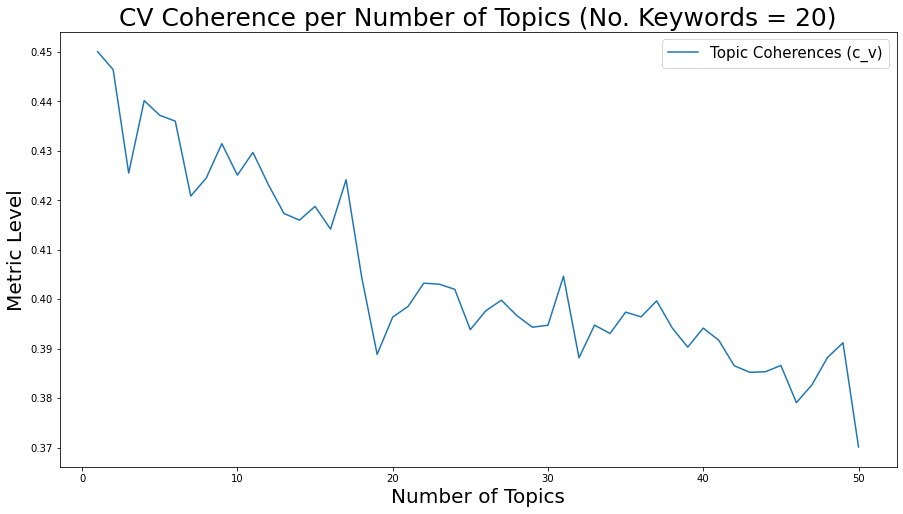

In [163]:
# visualization of CV Coherence

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_cv, label='Topic Coherences (c_v)')
#ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherences (u_mass)')

#ax.set_ylim([-3, y_max])

ax.axes.set_title('CV Coherence per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=15)
plt.show() 

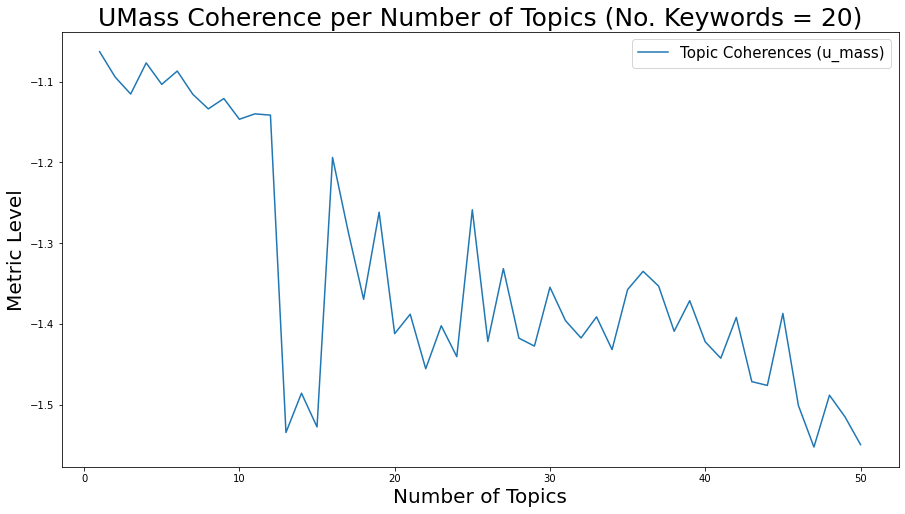

In [164]:
# visualization of UMass Coherence

plt.figure(figsize=(15,8))
#ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_cv, label='Topic Coherences (c_v)')
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherences (u_mass)')

#ax.set_ylim([-3, y_max])

ax.axes.set_title('UMass Coherence per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=15)
plt.show() 

In [165]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [166]:
lda_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(lda_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(lda_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    lda_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(lda_stability[i]).mean() for i in num_topics[:-1]]

#### Mean Stability and CV Coherence

In [167]:
# calculate mean stabilities and coherence (cv) difference and find max distance

coh_sta_diffs = [lda_coherences_cv[i] - mean_stabilities[i] for i in range(num_topics[-2])]
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

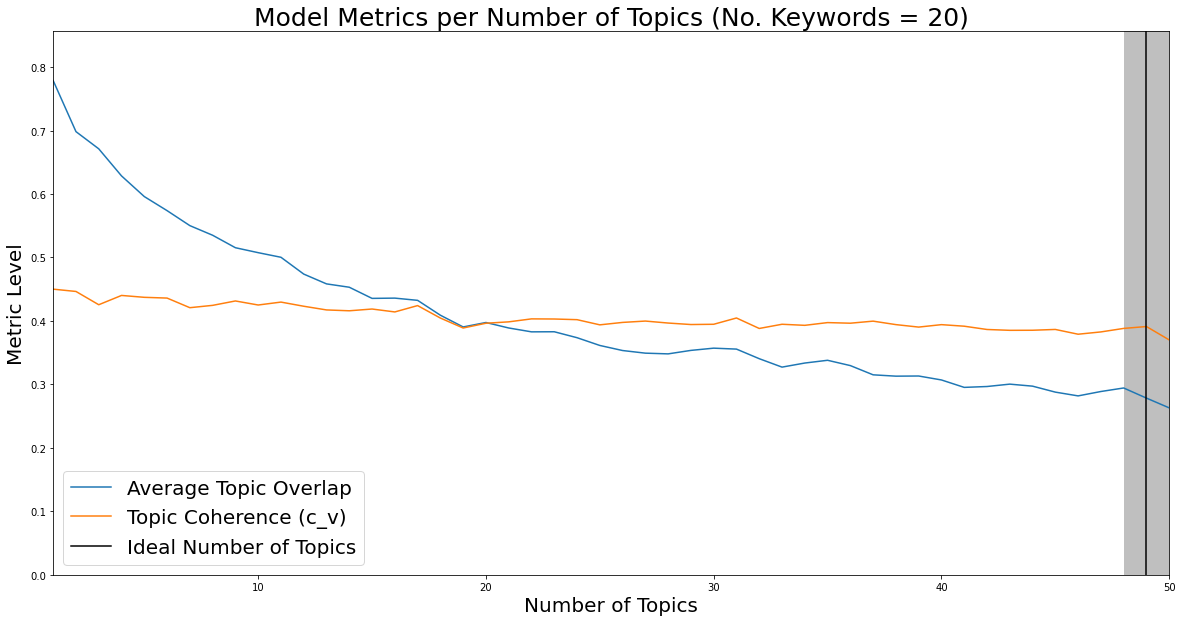

In [168]:
# plot average topic overlap, topic coherence (c_v) and ideal number of topics

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_cv, label='Topic Coherence (c_v)')
# ax = sns.lineplot(x=num_topics[:-1], y=lda_perplexity, label='Topic Perplexity')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(lda_coherences_cv)) + (0.10 * max(max(mean_stabilities), max(lda_coherences_cv)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

#### Mean Stability and UMass Coherence

In [219]:
# calculate coherence (umass) and mean stabilities difference and find max distance

coh_sta_diffs = [lda_coherences_umass[i] - mean_stabilities[i] for i in range(num_topics[-2])]
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

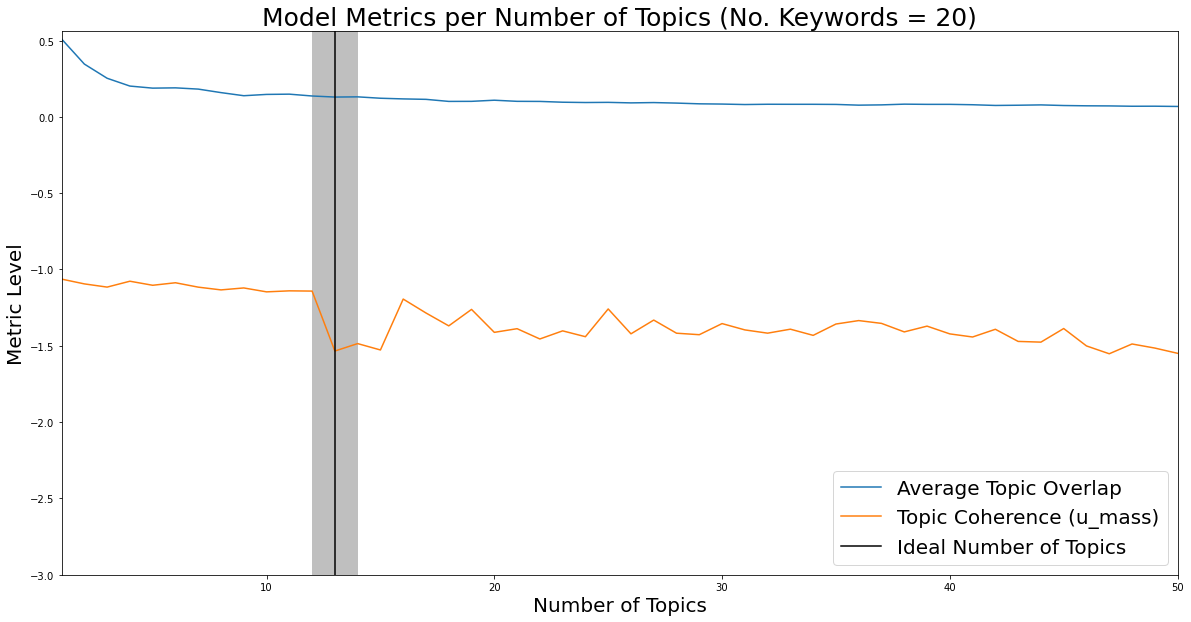

In [220]:
# plot average topic overlap, topic coherence (umass) and ideal number of topics

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherence (u_mass)')
#ax = sns.lineplot(x=num_topics[:-1], y=lda_perplexity, label='Topic Perplexity')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(lda_coherences_umass)) + (0.10 * max(max(mean_stabilities), max(lda_coherences_umass)))
ax.set_ylim([-3, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

In [173]:
# print ideal number of topic
ideal_topic_num

13

In [222]:
# print topics in idea model

for index, topic in lda_models[13].show_topics(num_topics=13,num_words=10, formatted=False):
    x = [x[0] for x in topic]
    print ('Topic: {} \nTopics: {}'.format(index,x))

Topic: 0 
Topics: ['brain', 'fog', 'headache', 'fatigue', 'pain', 'day', 'go', 'smell', 'sleep', 'chest']
Topic: 1 
Topics: ['pain', 'chest', 'headache', 'fatigue', 'cough', 'smell', 'symptom', 'start', 'go', 'day']
Topic: 2 
Topics: ['day', 'symptom', 'smell', 'headache', 'taste', 'feel', 'bad', 'cough', 'pain', 'much']
Topic: 3 
Topics: ['fatigue', 'pain', 'smell', 'sob', 'headache', 'day', 'cough', 'taste', 'start', 'feel']
Topic: 4 
Topics: ['headache', 'smell', 'taste', 'pain', 'day', 'start', 'cough', 'fatigue', 'loss', 'fever']
Topic: 5 
Topics: ['day', 'bad', 'get', 'start', 'loss', 'feel', 'headache', 'home', 'cough', 'fatigue']
Topic: 6 
Topics: ['fatigue', 'headache', 'taste', 'start', 'cough', 'symptom', 'smell', 'go', 'feel', 'body']
Topic: 7 
Topics: ['pain', 'start', 'headache', 'fatigue', 'smell', 'cough', 'taste', 'fever', 'get', 'go']
Topic: 8 
Topics: ['fatigue', 'headache', 'pain', 'symptom', 'start', 'heart', 'feel', 'chest', 'brain', 'fog']
Topic: 9 
Topics: ['sym

In [224]:
# print topics in idea model

for index, topic in lda_models[25].show_topics(num_topics=25,num_words=10, formatted=False):
    x = [x[0] for x in topic]
    print ('Topic: {} \nTopics: {}'.format(index,x))

Topic: 0 
Topics: ['brain', 'fog', 'headache', 'fatigue', 'increase', 'heart', 'work', 'pain', 'chest', 'continue']
Topic: 1 
Topics: ['pain', 'chest', 'fatigue', 'symptom', 'headache', 'cough', 'muscle', 'day', 'work', 'go']
Topic: 2 
Topics: ['day', 'symptom', 'headache', 'bad', 'cough', 'much', 'work', 'time', 'feel', 'go']
Topic: 3 
Topics: ['pain', 'sob', 'fatigue', 'headache', 'time', 'cough', 'brain', 'day', 'feel', 'chest']
Topic: 4 
Topics: ['headache', 'pain', 'taste', 'smell', 'start', 'cough', 'day', 'chest', 'loss', 'fever']
Topic: 5 
Topics: ['day', 'get', 'bad', 'sob', 'feel', 'symptom', 'go', 'fatigue', 'headache', 'work']
Topic: 6 
Topics: ['headache', 'fatigue', 'symptom', 'difficulty', 'breathe', 'start', 'walk', 'taste', 'feel', 'back']
Topic: 7 
Topics: ['pain', 'start', 'get', 'fatigue', 'cough', 'breath', 'headache', 'chest', 'fever', 'work']
Topic: 8 
Topics: ['pain', 'heart', 'chest', 'memory', 'headache', 'symptom', 'fatigue', 'start', 'severe', 'issue']
Topic

# Method 2: NMF

In [175]:
from gensim.models import Nmf
# run NMF model for number of topics = 1-50

num_topics = list(range(52)[1:])
num_keywords = 20
nmf_models = {}
nmf_topics = {}

for i in num_topics:
    nmf_models[i] = Nmf(
        corpus=corpus,
        num_topics=i,
        id2word=id2word,
        random_state=12321
    )

    shown_topics = nmf_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    
    nmf_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [176]:
# Store TF-IDF Vectorizer
data_tfidf = TfidfVectorizer()

### Model Evaluation (NMF)

In [179]:
# average of overlapping top 20 words among topics per number of topics

nmf_count = {}
nmf_count_list = []
for i in range(1, len(num_topics)):
    count_per_model = []
    for j in range (0, len(nmf_topics[i])-1):
        topic1 = nmf_topics[i][j]
        rest_of_topics = list(nmf_topics.values())
        count_per_1topic = []
        for topic2 in rest_of_topics.pop(j):
            count_tmp = sum(t in topic1 for t in topic2)
            # store count per topic compared with rest of topic to a list
            count_per_1topic.append(count_tmp)
            # average count of overlap per topic
            count_per_1topic_1 = np.average(count_per_1topic)
        # append and average count per topic to get count per model 
        count_per_model.append(count_per_1topic_1)
        # store count per model in list
        nmf_count[i] = np.average(count_per_model)

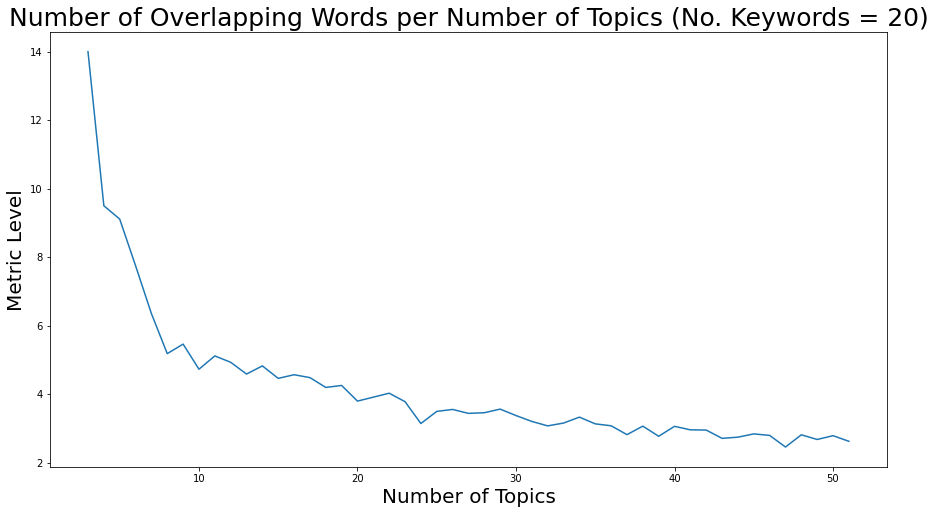

In [900]:
# visualization of Number of Overlapping Words per Number of Topics (No. Keywords = 10)
plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[2:51], y=nmf_count.values())

ax.axes.set_title('Number of Overlapping Words per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
#plt.legend(fontsize=20)
plt.show()

In [177]:
# get coherence (c_v)
nmf_coherences_cv = [CoherenceModel(model=nmf_models[i], texts=data_words_nostops, coherence='c_v').get_coherence()\
                  for i in num_topics[:-1]]

# get coherence (u_mass)
nmf_coherences_umass = [CoherenceModel(model=nmf_models[i], corpus=corpus, coherence='u_mass').get_coherence()\
                  for i in num_topics[:-1]]

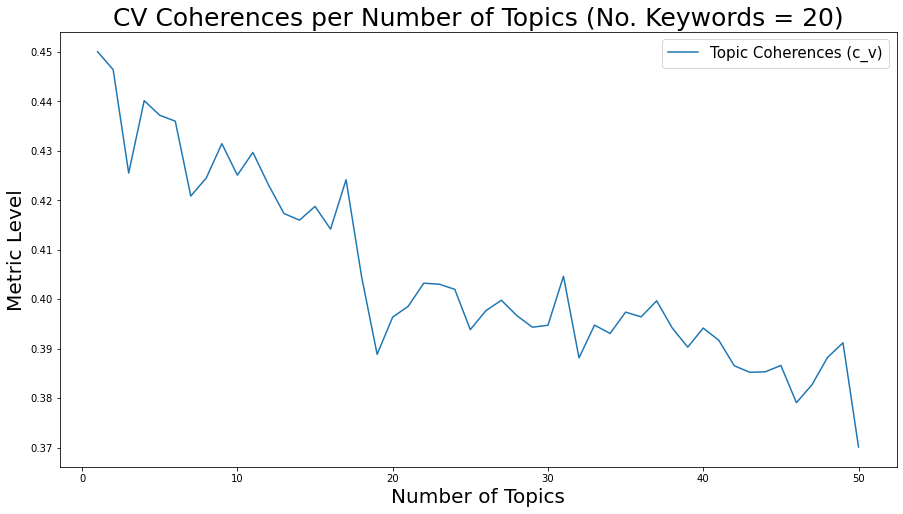

In [184]:
# visualization of CV Coherence

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_cv, label='Topic Coherences (c_v)')
#ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherences (u_mass)')


ax.axes.set_title('CV Coherences per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=15)
plt.show() 

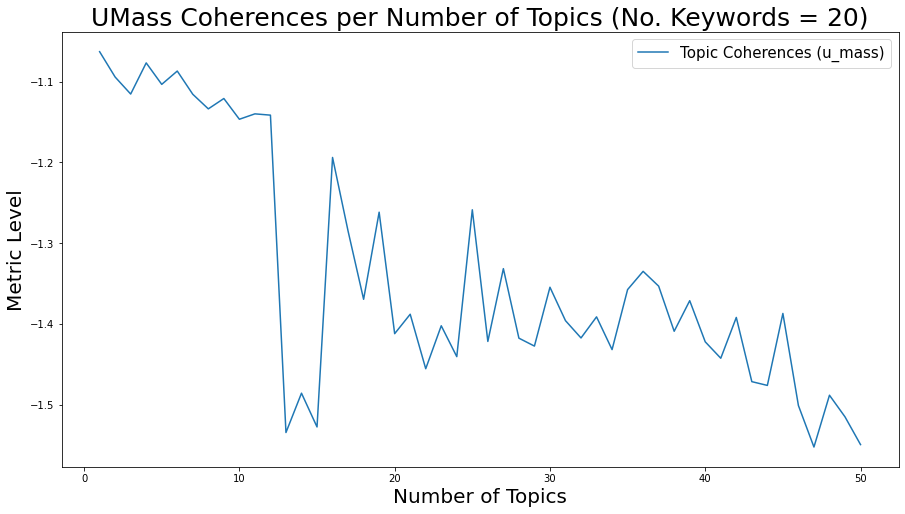

In [185]:
# visualization of UMass Coherence

plt.figure(figsize=(15,8))
#ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_cv, label='Topic Coherences (c_v)')
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherences (u_mass)')

ax.axes.set_title('UMass Coherences per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=15)
plt.show() 

In [186]:
nmf_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(nmf_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(nmf_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    nmf_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(nmf_stability[i]).mean() for i in num_topics[:-1]]

#### Coherence (c_v)

In [187]:
# calculate coherence (cv) and mean stabilities difference and find max distance

coh_sta_diffs = [nmf_coherences_cv[i] - mean_stabilities[i] for i in range(num_topics[-2])]
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

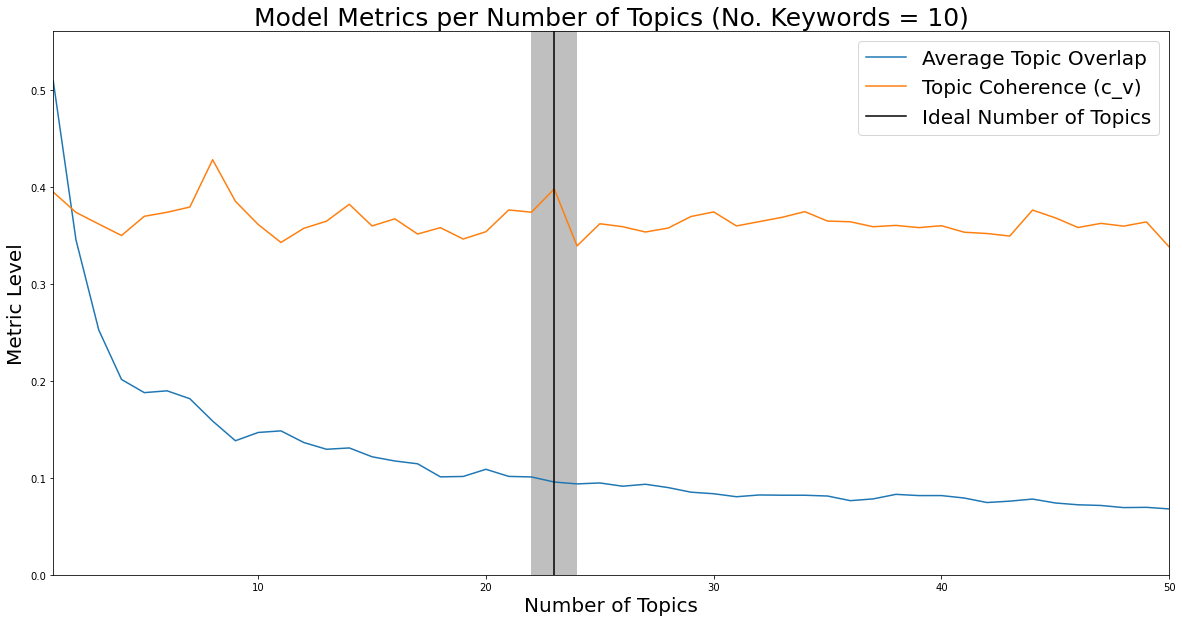

In [188]:
# plot average topic overlap, topic coherence (cv) and ideal number of topics

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=nmf_coherences_cv, label='Topic Coherence (c_v)')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(nmf_coherences_cv)) + (0.10 * max(max(mean_stabilities), max(nmf_coherences_cv)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics (No. Keywords = 10)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

In [189]:
ideal_topic_num

23

In [225]:
# print topics of best model

list_tmp = [(index, topic) for index, topic in enumerate(nmf_topics[23])]
for index, topic in list_tmp:
    print ('Topic: {} \nTopics: {}'.format(index, topic[:-10]))

Topic: 0 
Topics: ['cough', 'pain', 'chest', 'low', 'smell', 'back', 'neck', 'fever', 'breath', 'start']
Topic: 1 
Topics: ['headache', 'start', 'feel', 'pain', 'much', 'go', 'chest', 'day', 'normal', 'week']
Topic: 2 
Topics: ['pain', 'cough', 'headache', 'fatigue', 'taste', 'ache', 'smell', 'body', 'chest', 'sob']
Topic: 3 
Topics: ['work', 'day', 'get', 'feel', 'start', 'much', 'home', 'migraine', 'issue', 'go']
Topic: 4 
Topics: ['go', 'day', 'use', 'sick', 'heart', 'time', 'get', 'inhaler', 'nebulizer', 'even']
Topic: 5 
Topics: ['smell', 'taste', 'loss', 'symptom', 'fatigue', 'get', 'day', 'bad', 'time', 'issue']
Topic: 6 
Topics: ['pain', 'fatigue', 'muscle', 'visit', 'begin', 'headache', 'resolve', 'extreme', 'ear', 'joint']
Topic: 7 
Topics: ['right', 'back', 'go', 'work', 'chest', 'head', 'day', 'cough', 'headache', 'side']
Topic: 8 
Topics: ['fatigue', 'first', 'body', 'sleep', 'day', 'extreme', 'smell', 'high', 'get', 'notice']
Topic: 9 
Topics: ['taste', 'smell', 'feel', '

#### Coherence (u_mass)

In [191]:
# calculate coherence (umass) and mean stabilities difference and find max distance

coh_sta_diffs = [nmf_coherences_umass[i] - mean_stabilities[i] for i in range(num_topics[-2])]
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

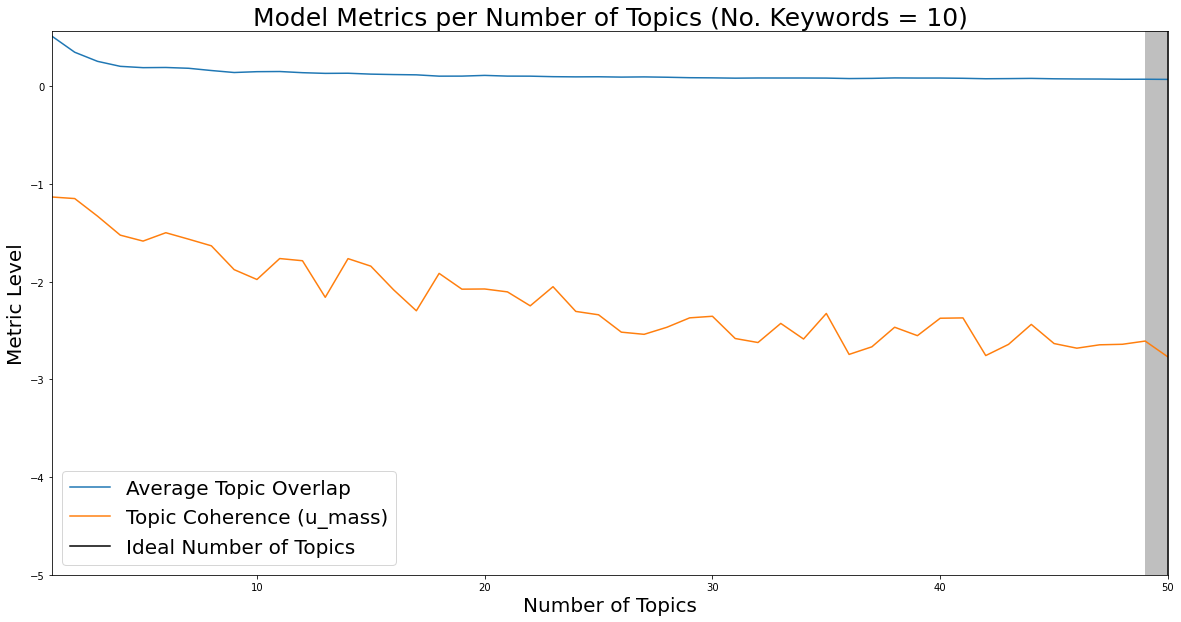

In [192]:
# plot average topic overlap, topic coherence (umass) and ideal number of topics

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=nmf_coherences_umass, label='Topic Coherence (u_mass)')
#ax = sns.lineplot(x=num_topics[:-1], y=lda_perplexity, label='Topic Perplexity')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(nmf_coherences_umass)) + (0.10 * max(max(mean_stabilities), max(nmf_coherences_cv)))
ax.set_ylim([-5, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics (No. Keywords = 10)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

In [193]:
ideal_topic_num

50

# Method 3: BTM

In [195]:
import bitermplus as btm
from sklearn.feature_extraction.text import CountVectorizer

# join sentences
data_sentences_list = []
for sentence in data_words_nostops:
    sentence_processed = (' ').join(sentence)
    data_sentences_list.append(sentence_processed)

data_sentences = pd.DataFrame(data_sentences_list)
data_sentences.head()

0
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              drive noah am pm feel good day tired bedtime ear ring moderate headache ear ring fatigue go museum noise walk quite bit
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [196]:
# pre-processing for btm

texts = data_sentences_list

# obtain terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
tf = np.array(X.sum(axis=0)).ravel()

# Vectorize documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))

# Generate biterms
biterms = btm.get_biterms(docs_vec)

#### Bitermplus

In [197]:
# run BTM model for number of topics = 1-50 using bitermplus

num_topics = list(range(52)[1:])
num_keywords = 20
btm_models = {}
btm_topics = {}

for i in num_topics:
    btm_models[i] = btm.BTM(
        X, vocabulary, seed=12, T=i, M=20, alpha=50/8, beta=0.01)
    btm_models[i].fit(biterms, iterations=20)
    p_zd = btm_models[i].transform(docs_vec)
    
    shown_topics_dict = btm.get_top_topic_words(btm_models[i], words_num=num_keywords).to_dict('list')
    shown_topics = list(shown_topics_dict.items())
  
    btm_topics[i] = [[word for word in topic[1]] for topic in shown_topics]

100%|██████████| 633/633 [00:00<00:00, 10621.51it/s]


In [198]:
# average of overlapping top 20 words among topics per number of topics

btm_count = {}
btm_count_list = []
for i in range(1, len(num_topics)):
    count_per_model = []
    for j in range (0, len(btm_topics[i])-1):
        topic1 = btm_topics[i][j]
        count_per_1topic = []
        for topic1 in btm_topics[i]:
            for topic2 in btm_topics[i]:
                if topic2 != topic1:
                    count_tmp = sum(t in topic1 for t in topic2)
                    count_per_1topic.append(count_tmp)
                    count_per_1topic_1 = np.average(count_per_1topic)
            
        count_per_model.append(count_per_1topic_1)
        btm_count[i] = np.average(count_per_model)

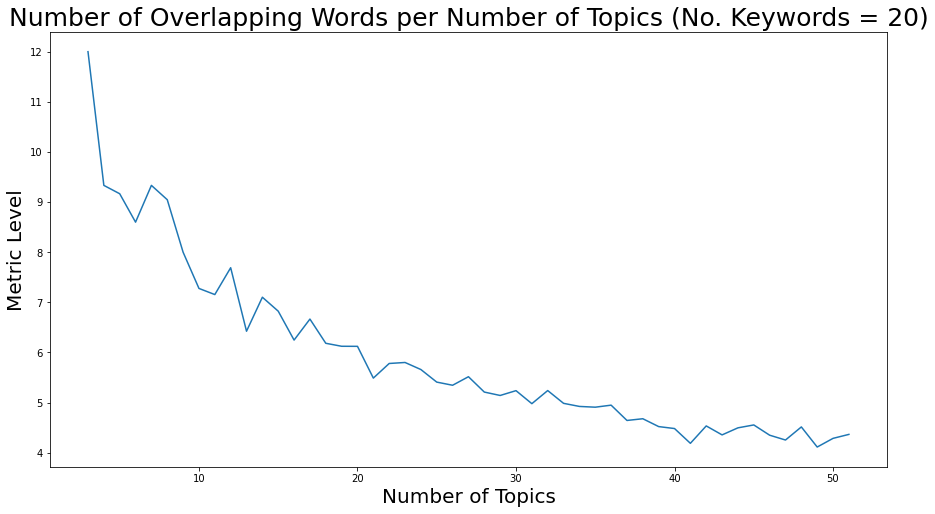

In [200]:
# visualization of Numver of Overlapping Words per Number of Topics (No. Keywords = 10)
plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[2:51], y=btm_count.values())

ax.axes.set_title('Number of Overlapping Words per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
#plt.legend(fontsize=20)
plt.show()

In [199]:
# calculate perplexity
btm_perplexity = [btm_models[i].perplexity_\
                 for i in num_topics[:-1]]

#calculate coherences
btm_coherences = [np.average(btm_models[i].coherence_)\
                for i in num_topics[:-1]]

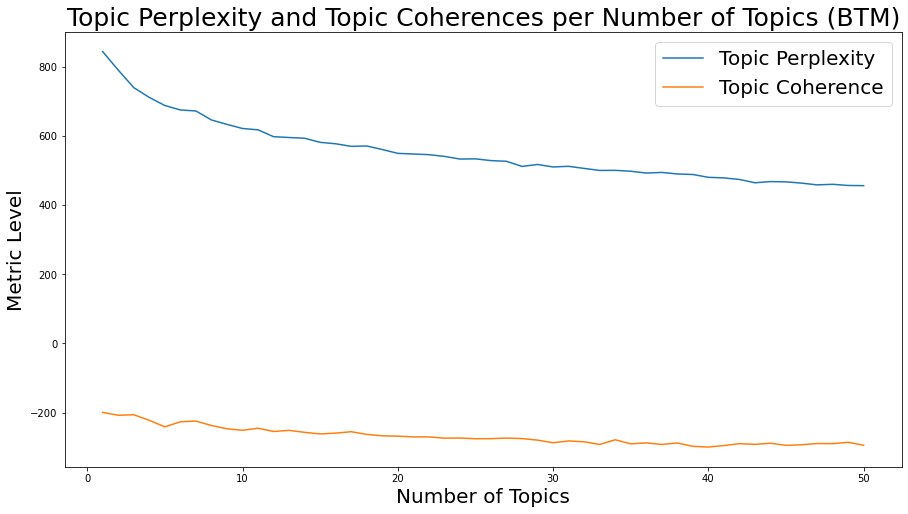

In [201]:
# visualization

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[:-1], y=btm_perplexity, label='Topic Perplexity')
ax = sns.lineplot(x=num_topics[:-1], y=btm_coherences, label='Topic Coherence')

ax.axes.set_title('Topic Perplexity and Topic Coherences per Number of Topics (BTM)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

In [226]:
list_tmp = [(index, topic) for index, topic in enumerate(btm_topics[25])]
for index, topic in list_tmp:
    print ('Topic: {} \nTopics: {}'.format(index, topic[:-10]))

Topic: 0 
Topics: ['start', 'symptom', 'much', 'pain', 'work', 'go', 'visit', 'feel', 'time', 'day']
Topic: 1 
Topics: ['go', 'day', 'walk', 'get', 'work', 'much', 'bad', 'feel', 'hour', 'take']
Topic: 2 
Topics: ['pain', 'chest', 'brain', 'headache', 'fog', 'start', 'issue', 'nausea', 'fatigue', 'normal']
Topic: 3 
Topics: ['right', 'pain', 'head', 'back', 'leg', 'left', 'leave', 'side', 'feel', 'foot']
Topic: 4 
Topics: ['brain', 'fatigue', 'fog', 'issue', 'muscle', 'start', 'headache', 'anxiety', 'sleep', 'symptom']
Topic: 5 
Topics: ['brain', 'fog', 'bad', 'fatigue', 'headache', 'smell', 'symptom', 'pain', 'get', 'much']
Topic: 6 
Topics: ['smell', 'taste', 'food', 'much', 'day', 'start', 'continue', 'come', 'begin', 'symptom']
Topic: 7 
Topics: ['back', 'start', 'work', 'feel', 'smell', 'fatigue', 'day', 'taste', 'come', 'symptom']
Topic: 8 
Topics: ['see', 'symptom', 'chest', 'normal', 'heart', 'visit', 'order', 'continue', 'blood', 'liver']
Topic: 9 
Topics: ['work', 'go', 'feel

# Method 4: Corex

In [251]:
data_corex = data_sentences.copy()
data_corex.columns = ['text']
data_corex.head()

text
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              drive noah am pm feel good day tired bedtime ear ring moderate headache ear ring fatigue go museum noise walk quite bit
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [252]:
# transform data into matrix

import scipy.sparse as ss

vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(data_corex.text)

doc_word = ss.csr_matrix(doc_word)

doc_word.shape

(633, 4501)

In [253]:
# create word labels for each column 
words = list(np.asarray(vectorizer.get_feature_names()))

/Users/cynthiayip/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [254]:
import scipy.sparse as ss
from corextopic import corextopic as ct

# Define a matrix where rows are samples (docs) and columns are features (words)
X = doc_word

# Train the CorEx topic model
# run CorEx for num_topics = 1-50

num_topics = list(range(52)[1:])
corex_models = {}

for i in num_topics:
    corex_models[i] = ct.Corex(n_hidden=i, words=words, max_iter=200, verbose=False, seed=1)  
    corex_models[i].fit(X, words=words) #, docs=docs)

In [255]:
# Display top n words for each topic identified
def display_topics(model, words_count):
    topic_list = []
    for i, topic_words in enumerate(model.get_topics(n_words = words_count)):
        topic_words = [words[0] for words in topic_words if words[1] > 0]
        topic_list.append(topic_words)
    return topic_list
         #print("Topic #{}: {}".format(i+1, ", ".join(topic_words)))
words_count = 10

In [256]:
corex_topics = {}
for i in range(2, len(num_topics)):
    corex_topics[i] = display_topics(corex_models[i], 10)

In [257]:
corex_count = {}
corex_count_list = []
for i in range(2, len(num_topics)):
    count_per_model = []
    for j in range (0, len(corex_topics[i])-1):
        topic1 = corex_topics[i][j]
        count_per_1topic = []
        for topic_1 in corex_topics[i]:
            for topic2 in corex_topics[i]:
                if topic2 != topic1:
                    count_tmp = sum(t in topic1 for t in topic2)
                    count_per_1topic.append(count_tmp)
                    count_per_1topic_1 = np.average(count_per_1topic)
            
            count_per_1topic.append(count_tmp)
         
            count_per_1topic_1 = np.average(count_per_1topic)
        # append and average count per topic to get count per model 
        count_per_model.append(count_per_1topic_1)
        # store count per model in list
        corex_count[i] = np.average(count_per_model)

corex_count

{2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0}

In [259]:
# Get coherence score
corex_coherences_cv = [CoherenceModel(topics=corex_topics[i], texts=data_words_nostops, corpus=corpus, dictionary=id2word, coherence='c_v').get_coherence()\
                       for i in num_topics[1:-1]]
corex_coherences_umass = [CoherenceModel(topics=corex_topics[i], texts=data_words_nostops, corpus=corpus, dictionary=id2word, coherence='u_mass').get_coherence()\
                       for i in num_topics[1:-1]]

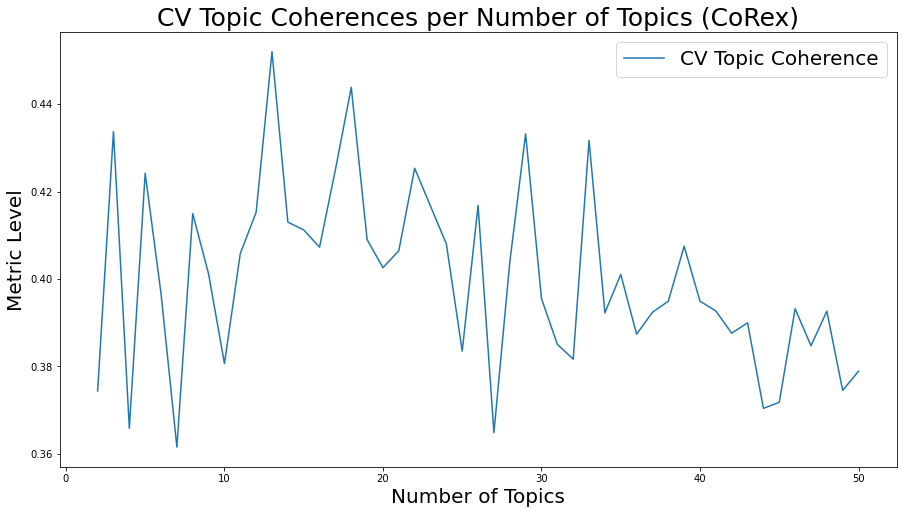

In [260]:
# visualization (CV topic coherence)

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[1:-1], y=corex_coherences_cv, label='CV Topic Coherence')

ax.axes.set_title('CV Topic Coherences per Number of Topics (CoRex)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

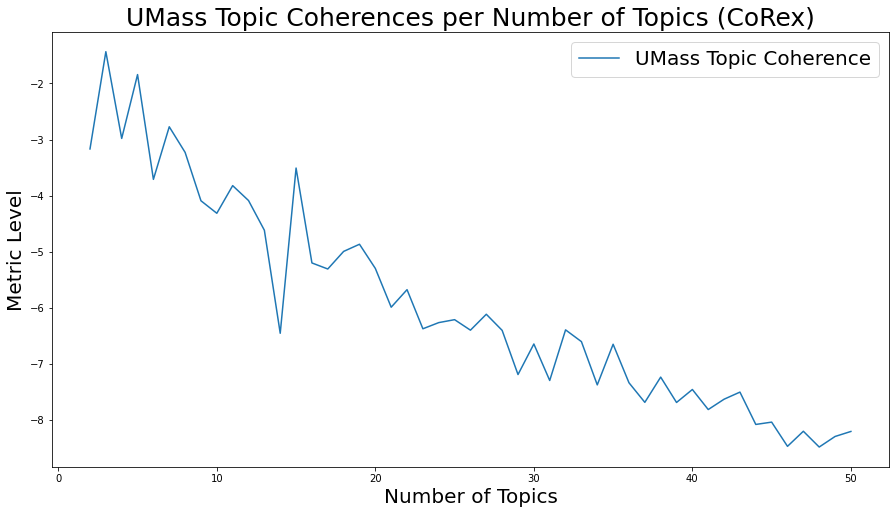

In [261]:
# visualization of coherence score (UMass)

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[1:-1], y=corex_coherences_umass, label='UMass Topic Coherence')

ax.axes.set_title('UMass Topic Coherences per Number of Topics (CoRex)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

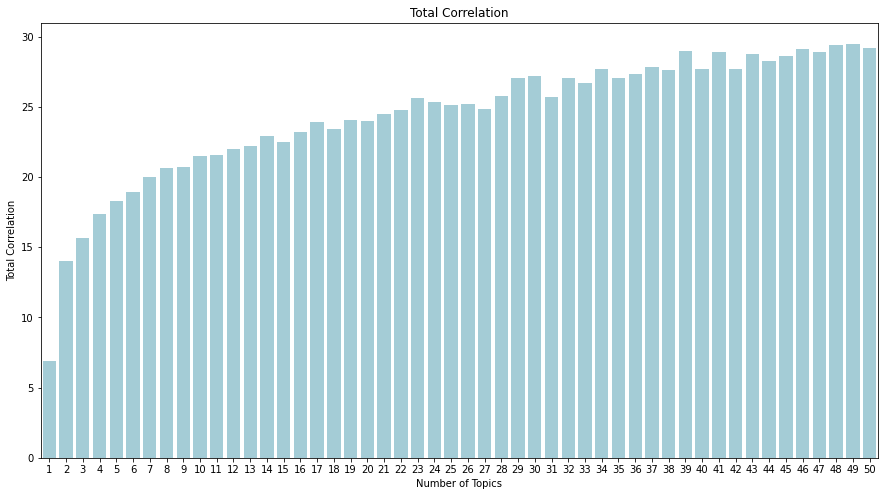

In [258]:
# overall TC and plot results
tc = [corex_models[i].tc for i in num_topics[:-1]]

# plot results
plt.figure(figsize=(15,8))
sns.barplot(x=num_topics[:-1], y=tc, label='Topic Correlation', color = '#9CD1DE').\
set(title='Total Correlation', xlabel = 'Number of Topics', ylabel = 'Total Correlation')

plt.show()

In [264]:
# print all topics from the best CorEx topic model
topics = corex_models[23].get_topics()
for n, topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: tank, quite, hysterectomy, result, indicate, hematologist, carry, visual, mood, teh
1: appt, discuss, job, worsen, recommend, pulmonologist, stuffy, response, wayne, physically
2: note, improvement, post, progress, virtual, tend, recognize, ultrasound, itching, kid
3: day, hour, take, time, bed, also, night, week, year, never
4: see, scan, show, order, negative, ct, prescribe, blood, give, ekg
5: constipation, include, early, mostly, case, induce, panel, draw, tender, gi
6: feel, go, work, good, bad, get, back, throat, sore, well
7: liver, june, stress, cleveland, reduce, fatty, suffer, entire, assume, injury
8: home, admit, hospital, send, discharge, parkview, walk, release, clinic, oxygen
9: need, lung, advise, anti, cancer, restriction, contact, injection, strong, part
10: leg, hand, neck, left, side, foot, arm, face, ear, knee
11: much, life, stand, sit, hold, look, morning, evening, force, bathroom
12: normal, symptom, food, several, increase, improve, period, second, experienc

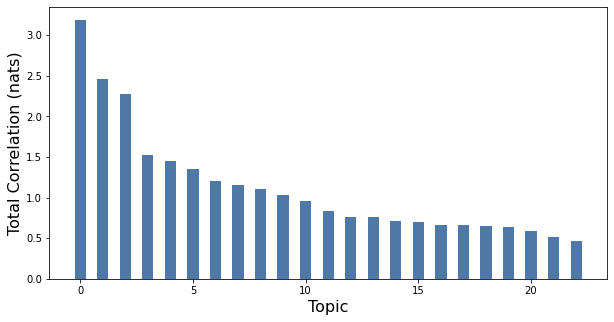

In [266]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_models[23].tcs.shape[0]), corex_models[23].tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

#### Anchored CoRex

In [267]:
# adding anchor words for semi supervised learning, topics = 8

def corex_anchor(X, words, num_of_topics, anchor_strength, anchor_words = []):
    anchored_topic_model = ct.Corex(n_hidden=num_of_topics, seed=2)
    anchored_topic_model.fit(X, words=words, anchors=anchor_words, anchor_strength=6)
    return anchored_topic_model.tc

num_of_topics = 10
anchor_strength = list(range(21)[1:])
anchored_topic_models = {}

for i in anchor_strength:
    anchor_words = [
        ['pain', 'headache'], 
        ['anxiety', 'mental'], 
        ['tired', 'fatigue'], 
        ['breath', 'shortness'], 
        ['diabetes'],
        ['pressure', 'blood'],
        'asthma',
        ['brainfog', 'brain', 'memory'],
        ['taste', 'smell', 'loss'],
        ['dizziness', 'vertigo', 'balance'],
    ]

    anchored_topic_models[i] = ct.Corex(n_hidden=num_of_topics, seed=2)
    anchored_topic_models[i].fit(X, words=words, anchors=anchor_words, anchor_strength=i)

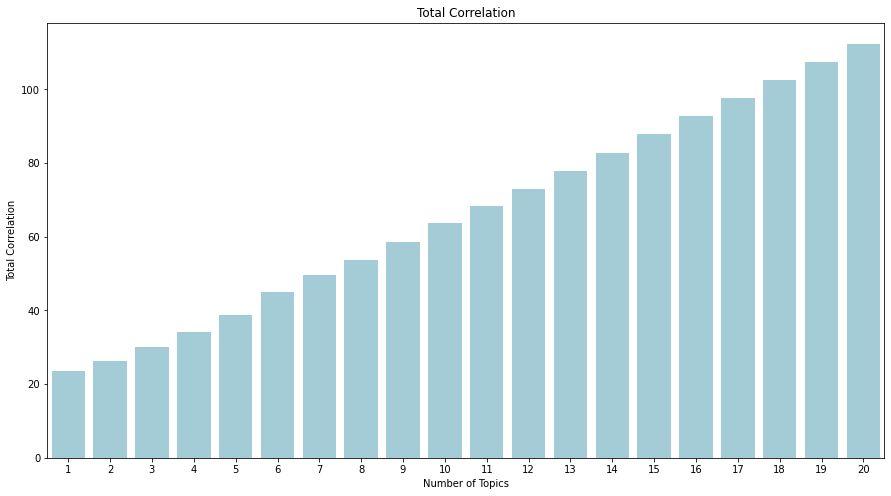

In [268]:
# overall TC and plot results
anchored_tc = [anchored_topic_models[i].tc for i in anchor_strength]

# plot results
plt.figure(figsize=(15,8))
sns.barplot(x=anchor_strength, y=anchored_tc, label='Topic Correlation', color = '#9CD1DE').\
set(title='Total Correlation', xlabel = 'Number of Topics', ylabel = 'Total Correlation')

#ax.axes.set_title('Total Correlation', fontsize=25)
#ax.set_ylabel('Number of Topics', fontsize=20)
#ax.set_xlabel('Total Correlation', fontsize=20)
#plt.legend(fontsize=20)
plt.show()

In [269]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_models[2].get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: pain, headache, chest, muscle, throat, cough, sore, joint, fever, nausea
1: anxiety, year, able, come, never, think, use, long, tell, struggle
2: fatigue, day, go, much, hour, get, take, feel, week, try
3: breath, shortness, short, catch, minute, pulmonary, plateau, store, soup, consistently
4: diabetes, refer, prescribe, cause, recommend, heartbeat, pet, calf, realize, parkview
5: blood, pressure, show, lung, high, right, side, clot, home, negative
6: asthma, normal, great, function, husband, stop, law, injection, lay, ent
7: brain, fog, begin, drive, forgetfulness, tooth, dysfunction, process, internal, blur
8: smell, taste, loss, lose, sense, chemical, sweet, meat, sensitivity, chart
9: dizziness, symptom, balance, steroid, office, order, increase, period, lab, random


In [270]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_models[11].get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: pain, headache, joint, muscle, chest, throat, abdominal, musclejoint, foot, jaw
1: anxiety, mental, depression, increase, evening, difficulty, last, recognize, palpitation, intense
2: fatigue, tired, body, cough, extreme, fever, ache, improve, sleep, sob
3: breath, shortness, short, catch, minute, pulmonary, teh, breathlessness, liter, hte
4: diabetes, much, see, day, take, say, feel, go, hour, bed
5: blood, pressure, clot, high, lung, low, sinus, dehydrate, liver, sugar
6: asthma, normal, first, make, ct, improvement, allergy, need, full, husband
7: brain, memory, fog, brainfog, word, forgetfulness, begin, complete, conversation, tooth
8: smell, taste, loss, lose, sense, chemical, chart, sweet, metallic, regain
9: dizziness, balance, vertigo, hr, nausea, continue, stand, tend, tingling, turn


In [271]:
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_models[20].get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: pain, headache, joint, muscle, chest, throat, low, abdominal, sore, musclejoint
1: anxiety, mental, depression, palpitation, medical, worker, panic, intense, concern, induce
2: fatigue, tired, body, cough, extreme, fever, ache, improve, sob, appetite
3: breath, shortness, short, catch, pulmonary, minute, flow, teh, afterwards, breathlessness
4: diabetes, much, see, day, take, get, feel, hour, go, say
5: blood, pressure, clot, lung, high, dehydrate, liver, sugar, like, xray
6: asthma, normal, function, first, allergy, rest, husband, improvement, need, check
7: brain, memory, fog, brainfog, word, forgetfulness, drive, begin, complete, tooth
8: smell, taste, loss, lose, sense, chemical, sweet, diarrhea, chart, regain
9: dizziness, balance, vertigo, nausea, clear, start, tingling, friend, suffer, focus


## Comparing LDA, NMF, BTM, and CoRex

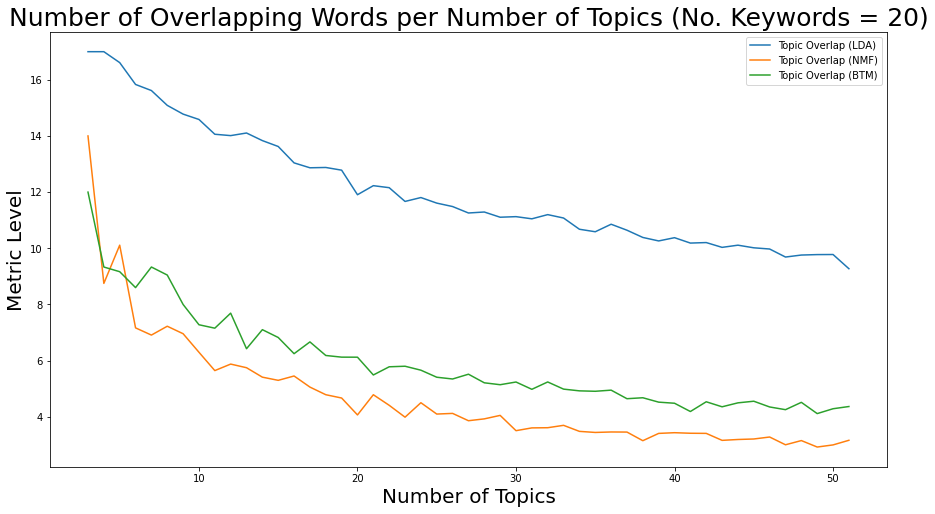

In [274]:
# visualization
# Comparison of Numver of Overlapping Words per Number of Topics (No. Keywords = 10)

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[2:51], y=lda_count.values(), label='Topic Overlap (LDA)')
ax = sns.lineplot(x=num_topics[2:51], y=nmf_count.values(), label='Topic Overlap (NMF)')
ax = sns.lineplot(x=num_topics[2:51], y=btm_count.values(), label='Topic Overlap (BTM)')

ax.axes.set_title('Number of Overlapping Words per Number of Topics (No. Keywords = 20)', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
#plt.legend(fontsize=20)
plt.show()

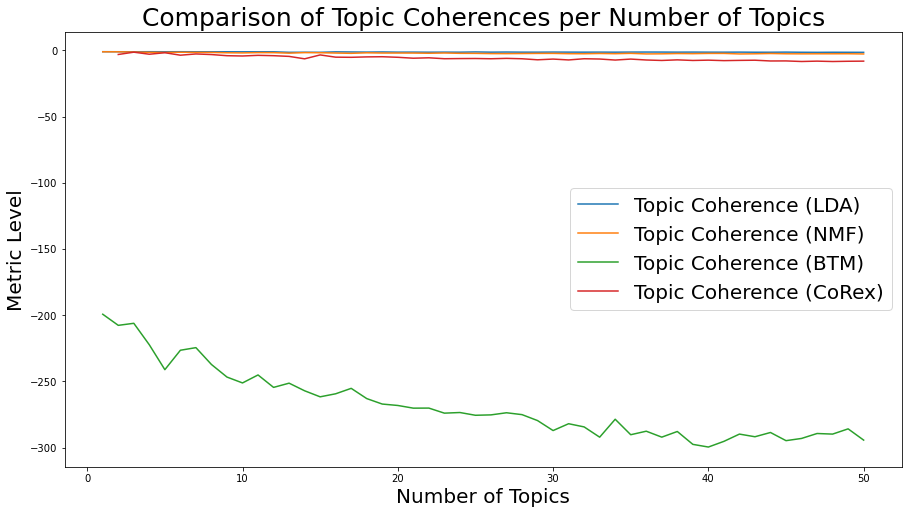

In [272]:
# visualization
# comparison between models (coherence)

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherence (LDA)')
ax = sns.lineplot(x=num_topics[:-1], y=nmf_coherences_umass, label='Topic Coherence (NMF)')
ax = sns.lineplot(x=num_topics[:-1], y=btm_coherences, label='Topic Coherence (BTM)')
ax = sns.lineplot(x=num_topics[1:-1], y=corex_coherences_umass, label='Topic Coherence (CoRex)')

ax.axes.set_title('Comparison of Topic Coherences per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

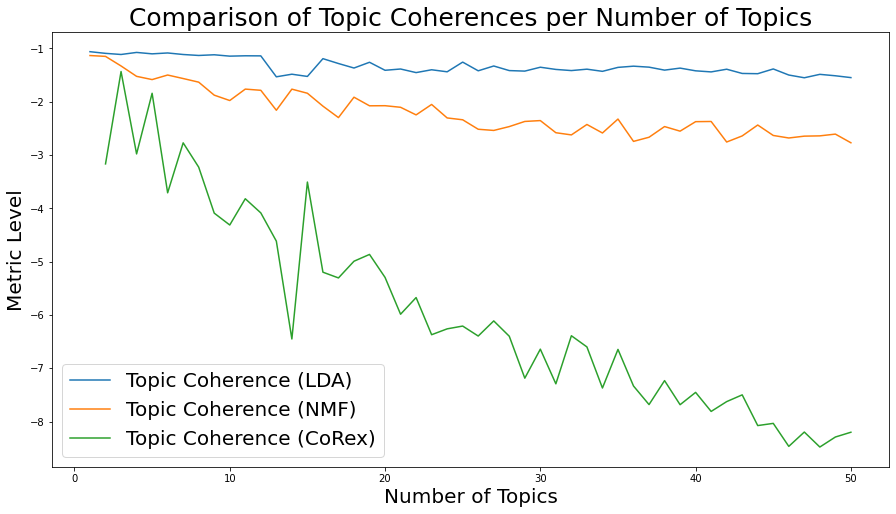

In [273]:
# visualization
# comparison between models (coherence)

plt.figure(figsize=(15,8))
ax = sns.lineplot(x=num_topics[:-1], y=lda_coherences_umass, label='Topic Coherence (LDA)')
ax = sns.lineplot(x=num_topics[:-1], y=nmf_coherences_umass, label='Topic Coherence (NMF)')
ax = sns.lineplot(x=num_topics[1:-1], y=corex_coherences_umass, label='Topic Coherence (CoRex)')

ax.axes.set_title('Comparison of Topic Coherences per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 